# Part 4
For part 4 of the project, you will use your MySQL database from parts 2-3 to answer meaningful questions for your stakeholder. They want you to use your hypothesis testing and statistics knowledge to answer 3 questions about what makes a successful movie.

## Questions to Answer
    - The stakeholder's first question is: does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

        - They want you to perform a statistical test to get a mathematically-supported answer.
        - They want you to report if you found a significant difference between ratings.
            - If so, what was the p-value of your analysis?
            - And which rating earns the most revenue?
        - They want you to prepare a visualization that supports your finding.
    - It is then up to you to think of 2 additional hypotheses to test that your stakeholder may want to know.

    - Some example hypotheses you could test:

        - Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?
        - Do movies released in 2020 earn less revenue than movies released in 2018?
            - How do the years compare for movie ratings?
        - Do some movie genres earn more revenue than others?
        - Are some genres higher rated than others?
        - etc.

## Specifications
### Your Data
    - A critical first step for this assignment will be to retrieve additional movie data to add to your SQL database.
        - You will want to use the TMDB API again and extract data for additional years.
        - You may want to review the optional lesson from Week 1 on "Using Glob to Load Many Files" to load and combine all of your API results for each year.
    - However, trying to extract the TMDB data for all movies from 2000-2022 could take >24 hours!
    - To address this issue, you should EITHER:
        - Define a smaller (but logical) period of time to use for your analyses (e.g., last 10 years, 2010-2019 (pre-pandemic, etc).
        - OR coordinate with cohort-mates and divide the API calls so that you can all download the data for a smaller number of years and then share your downloaded JSON data.


## Deliverables
    - You should use the same project repository you have been using for Parts 1-3 (for your portfolio).
        - Create a new notebook in your project repository just for the hypothesis testing (like "Part 4 - Hypothesis Testing.ipynb")
        - Make sure the results and visualization for all 3 hypotheses are in your notebook.

Please submit the link to your GitHub repository for this assignment.

In [1]:
#import packages
#MAKING FOLDERS AND LISTING
import os, time, json
import tmdbsimple as tmdb
import pandas as pd
from tqdm.notebook import tqdm_notebook
#create the folder for saving files (if it dosen't exist)
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['final_tmdb_data_2006.csv.gz',
 'tmdb_api_results_2010.json',
 'tmdb_api_results_2006.json',
 'title_basics_cleaned.csv.gz',
 'final_tmdb_data_2004.csv.gz',
 'tmdb_api_results_2007.json',
 'tmdb_api_results_2011.json',
 'advance_tf_data_pt1.csv',
 'title_ratings_cleaned.csv.gz',
 'tmdb_api_results_2020.json',
 'final_tmbd_data_2019.csv.gz',
 'tmdb_api_results_2016.json',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'hypothesis_data.csv.gz',
 'Untitled.mwb',
 'final_tmdb_data_2002.csv.gz',
 'tmdb_api_results_2017.json',
 'tmdb_api_results_2021.json',
 'tmdb_api_results_2022.json',
 'tmdb_api_results_2018.json',
 'tmdb_api_results_2002.json',
 'final_tmdb_data_2007.csv.gz',
 'tmdb_api_results_2014.json',
 'tmdb_api_results_2015.json',
 'final_tmdb_data_2021.csv.gz',
 'tmdb_api_results_2003.json',
 'final_tmdb_data_2005.csv.gz',
 'title-akas-us-only.csv',
 'tmdb_api_results_2019.json',
 'final_tmbd_data_2010.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 '.ipynb_checkpoints'

In [2]:
import json
with open('/Users/rowenahan/.secret/tmbd_api.json') as f:
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()


dict_keys(['client-id', 'api-key', 'api-read-token'])

In [3]:
#load tmdbsimple
import tmdbsimple as tmdb
tmdb.API_KEY = login["api-key"]

## Adding certification

In [4]:
def get_movie_with_rating(movie_id):
    """Adaoted from source = https://github.com/celiao/tmdbsimple"""
    #Get the movie object for the current id
    movie=tmdb.Movies(movie_id)

    #save the .info .releases dictionaries
    info = movie.info()

    releases = movie.releases()
    #Loop through countries in releases
    for c in releases["countries"]:
        #if the country appreviation ==US
        if c["iso_3166_1"]=='US':
            #save a "certification" key in info with the certification
            info['certification']=c['certification']

    return info

In [5]:
#Define list of years to get from API for outer loop
YEARS_TO_GET=[ 2017,2018,2019]

In [6]:
#load data(basic.csv)
basics=pd.read_csv('Data/title_basics_cleaned.csv.gz')
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama


In [7]:
def write_json(new_data, filename):
    """Appends a list of records (new_data) to a json file (filename). Adapted from: 
    https://www.geeksforgeeks.org/append-to-json-file-using-python/"""

    with open(filename,'r+') as file:
        #first we load existing data into a dict.
        file_data=json.load(file)
        #choose extend or append
        if (type(new_data)==list) & (type(file_data)==list):
            file_data.extend(new_data)
        else:
            file_data.append(new_data)
        #set file's current position at offset
        file.seek(0)
        #convert back to json
        json.dump(file_data,file)

In [8]:
errors = []
results=[]
#Start the OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc="YEARS", position=0):

    #Defining the JSON file to store results for year
    JSON_FILE=F'{FOLDER}tmdb_api_results_{YEAR}.json'
    #Check if file exists
    file_exists = os.path.isfile(JSON_FILE)

    #if it does not exist: create it
    if file_exists==False:
        #print a message indicating the file is being created
        print(f"Creating {JSON_FILE} for API results for {YEAR}.")
        #save an empty dict with just "imdb_id" to the new json file
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)

        #Saving new year as the current df
        df=basics.loc[basics["startYear"]==YEAR].copy()
        #saving movie ids to separate variable
        movie_ids=df["tconst"].copy()
        movie_ids
        
        #load existing data from json into a dataframe alled "previous_df"
        previous_df=pd.read_json(JSON_FILE)
        
        previous_df

        #filter out any ids that are already in the JSON_FILE
        movie_ids_to_get=movie_ids[~movie_ids.isin(previous_df['imdb_id'])]

        #Loop through movie_ids_to_get with a tqdm progress bar
        for movie_id in tqdm_notebook(movie_ids_to_get,
                                      f"Movies from {YEAR}"):
        
            #get index and movie id from list
            try:
                #Retrieve then data for the movie id
                temp=get_movie_with_rating(movie_id)
                #append/extend results to existing fil using a pre_made function
                write_json(temp,JSON_FILE)
                #short 20 ms sleep to prevent overwhelming server
                time.sleep(.02)
        
            except Exception as e:
                errors.append([movie_id,e])
                continue
        
final_year_df=pd.read_json(JSON_FILE)
csv_fname=f'{FOLDER}final_tmbd_data_{YEAR}.csv.gz'
final_year_df.to_csv(csv_fname,compression='gzip',index=False)
    #final_year_df=pd.read_json(JSON_FILE)
    #final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip",index=False)

YEARS:   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
import glob
q="Data/final_tmbd_data*.csv.gz"
chunked_files=sorted(glob.glob(q))
chunked_files[:5]


['Data/final_tmbd_data_2004.csv.gz',
 'Data/final_tmbd_data_2010.csv.gz',
 'Data/final_tmbd_data_2014.csv.gz',
 'Data/final_tmbd_data_2016.csv.gz',
 'Data/final_tmbd_data_2019.csv.gz']

In [18]:
final_df=[]
for file in chunked_files:
    temp_df=pd.read_csv(file,lineterminator='\n')
    final_df.append(temp_df)

df_combined=pd.concat(final_df)
df_combined

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0122247,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",NaN,27743.0,en,Serial Killing 101,...,0.0,89.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Serial Killing 101,0.0,5.750,12.0,R
2,tt0146803,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,46730.0,en,"Goodnight, Joseph Parker",...,0.0,0.0,[],Released,When there's no place left to go but home,"Goodnight, Joseph Parker",0.0,6.000,1.0,NaN
3,tt0159290,0.0,/atFOPVD3AKSj16ImD1MJfIklf90.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,101917.0,nl,Bluebird,...,0.0,77.0,"[{'english_name': 'Dutch', 'iso_639_1': 'nl', ...",Released,"Merel, a talented young girl, is suddenly gett...",Bluebird,0.0,6.300,9.0,NaN
4,tt0167190,0.0,/qdTUAwQKQ9n7PfZeVJzs7sOP8S8.jpg,"{'id': 17235, 'name': 'Hellboy Collection', 'p...",66000000.0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...",NaN,1487.0,en,Hellboy,...,99318987.0,122.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",Released,From the dark side to our side.,Hellboy,0.0,6.665,6405.0,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4908,tt9906644,0.0,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,...,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Manoharam,0.0,6.042,12.0,NaN
4909,tt9913660,0.0,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,...,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.000,1.0,NaN
4910,tt9913872,0.0,/a0kySBmMZ77AqmNA3pDu45GsbCp.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,800030.0,es,De la piel del Diablo,...,0.0,0.0,[],Released,NaN,De la piel del Diablo,0.0,8.200,3.0,NaN
4911,tt9914942,0.0,/tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,598553.0,ca,La vida sense la Sara Amat,...,0.0,71.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Released,NaN,Life without Sara Amat,0.0,7.700,8.0,NaN


In [19]:
df_combined.columns

Index(['imdb_id', 'adult', 'backdrop_path', 'belongs_to_collection', 'budget',
       'genres', 'homepage', 'id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'certification'],
      dtype='object')

In [ ]:
#g=df_combined.loc[df_combined['certification']=='G'].copy()
#pg=df_combined.loc[df_combined['certification']=='PG'].copy()
#pg_13=df_combined.loc[df_combined['certification']=='PG-13'].copy()
#r=df_combined.loc[df_combined['certification']=='R'].copy

In [20]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [21]:
data=df_combined['revenue']
mean=np.mean(data)
std=np.std(data)
min=np.min(data)
max=np.max(data)

In [22]:
## Saving the final combined dataframe
final_fname ='Data/final_hypothesis_data.csv.gz'
df_combined.to_csv(final_fname, compression='gzip', index=False)

In [23]:
df_combined.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0122247,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",NaN,27743.0,en,Serial Killing 101,...,0.0,89.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Serial Killing 101,0.0,5.750,12.0,R
2,tt0146803,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,46730.0,en,"Goodnight, Joseph Parker",...,0.0,0.0,[],Released,When there's no place left to go but home,"Goodnight, Joseph Parker",0.0,6.000,1.0,NaN
3,tt0159290,0.0,/atFOPVD3AKSj16ImD1MJfIklf90.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,101917.0,nl,Bluebird,...,0.0,77.0,"[{'english_name': 'Dutch', 'iso_639_1': 'nl', ...",Released,"Merel, a talented young girl, is suddenly gett...",Bluebird,0.0,6.300,9.0,NaN
4,tt0167190,0.0,/qdTUAwQKQ9n7PfZeVJzs7sOP8S8.jpg,"{'id': 17235, 'name': 'Hellboy Collection', 'p...",66000000.0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...",NaN,1487.0,en,Hellboy,...,99318987.0,122.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",Released,From the dark side to our side.,Hellboy,0.0,6.665,6405.0,PG-13


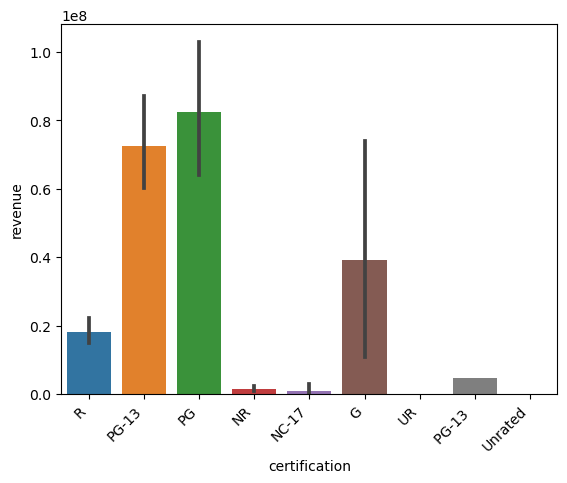

In [24]:
#graph certification and revenue
sns.barplot(data=df_combined,x="certification", y='revenue')
plt.xticks(rotation=45, ha="right");

In [25]:
#call value counts() on certification
df_combined['certification'].value_counts()

R          1439
NR          978
PG-13       823
PG          412
G            95
NC-17        45
Unrated       2
UR            1
PG-13         1
Name: certification, dtype: int64

In [ ]:
#adjust pg-13
#df_combined['certification']=df_combined['certification'].replace('PG-13 ', 'PG-13')

In [ ]:
#checking to see if it works
#df_combined["certification"].value_counts()

In [26]:
#list of value wanted in certification
clist=['G','PG','PG-13','R']

In [27]:
#save new df as with filtered certification column
filter_df=df_combined[df_combined['certification'].isin(clist)]
filter_df.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
1,tt0122247,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",NaN,27743.0,en,Serial Killing 101,...,0.0,89.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Serial Killing 101,0.0,5.750,12.0,R
4,tt0167190,0.0,/qdTUAwQKQ9n7PfZeVJzs7sOP8S8.jpg,"{'id': 17235, 'name': 'Hellboy Collection', 'p...",66000000.0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...",NaN,1487.0,en,Hellboy,...,99318987.0,122.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",Released,From the dark side to our side.,Hellboy,0.0,6.665,6405.0,PG-13
5,tt0167456,0.0,/jyzuK6OgWzibgAblJzxANUHSZ2x.jpg,NaN,57000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.thunderbirdsmovie.com,14623.0,en,Thunderbirds,...,28283637.0,95.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Thunderbirds,0.0,4.930,270.0,PG
10,tt0204313,0.0,/hz4Tzv4jac2usrCpMUGJp4akkoK.jpg,"{'id': 12263, 'name': 'The Exorcist Collection...",80000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",NaN,11026.0,en,Exorcist: The Beginning,...,78000586.0,114.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Go back to where the horror began.,Exorcist: The Beginning,0.0,5.367,710.0,R
16,tt0224025,0.0,NaN,NaN,400000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,23594.0,en,Wild Roomies,...,0.0,88.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Some Things Never Change...,Wild Roomies,0.0,4.500,13.0,R


## ANOVA TEST

In [28]:
#Create groups dict.  
groups={}
#loop through all unique categories
for i in filter_df['certification'].unique():
    #Get series for group and rename
    data=filter_df.loc[filter_df['certification']==i,'revenue'].copy()

    #save into the dict
    groups[i]=data

groups.keys()

dict_keys(['R', 'PG-13', 'PG', 'G'])

In [29]:
#running normal test on each group and confirming there are >20 in each group
norm_results={}
for i,data in groups.items():
    stat, p=stats.normaltest(data)
    #save the p val. test statistic, ad the size of the group
    norm_results[i]={'n': len(data),
                    'p':p,
                    'test stat':stat,}

#convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
R,1439.0,0.000000e+00,1938.863465
PG-13,823.0,3.137461e-216,992.429932
PG,412.0,9.944999e-79,359.214305
G,95.0,2.777170e-31,140.717411


In [30]:
#checking sig with pandas
norm_results_df['sig']=norm_results_df['p']<.05
norm_results_df

,n,p,test stat,sig
R,1439.0,0.000000e+00,1938.863465,True
PG-13,823.0,3.137461e-216,992.429932,True
PG,412.0,9.944999e-79,359.214305,True
G,95.0,2.777170e-31,140.717411,True


In [31]:
#testing assumption of equal variance
stats.levene(*groups.values())

LeveneResult(statistic=35.56795773261617, pvalue=1.5044946759181e-22)

In [32]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
#save the labels as certification and revenue as values
values=filter_df['revenue']
labels=filter_df['certification']

In [33]:
#perform tukey's multiple comparison test and display the summary
tukeys_results=pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,PG,43226590.0445,0.0431,905559.4234,85547620.6657,True
G,PG-13,33374700.4795,0.1441,-6917620.652,73667021.6111,False
G,R,-20886804.9975,0.5227,-60276547.9282,18502937.9332,False
PG,PG-13,-9851889.565,0.6719,-32293169.3064,12589390.1764,False
PG,R,-64113395.042,0.0,-84890587.8845,-43336202.1996,True
PG-13,R,-54261505.477,0.0,-70512451.657,-38010559.2971,True
